In [8]:
#Main Code
import pygame
import neat
import os
import random
import time
import matplotlib.pyplot as plt
import numpy as np


pygame.font.init()
pygame.display.set_caption("AI learns to play Flappy Bird Game using NEAT")
DRAW_LINES = True
gen = 0
WIN_WIDTH=500
WIN_HEIGHT=600

BIRD_IMGS = [pygame.transform.scale2x(pygame.image.load(os.path.join("imgs","bird1.png"))),pygame.transform.scale2x(pygame.image.load(os.path.join("imgs","bird2.png"))),pygame.transform.scale2x(pygame.image.load(os.path.join("imgs","bird3.png")))]
PIPE_IMG = pygame.transform.scale2x(pygame.image.load(os.path.join("imgs","pipe.png")))
BASE_IMG = pygame.transform.scale2x(pygame.image.load(os.path.join("imgs","base.png")))
BG_IMG = pygame.transform.scale2x(pygame.image.load(os.path.join("imgs","bg2.png")))

STAT_FONT = pygame.font.SysFont("comicsans",50)

class Bird:
    IMGS = BIRD_IMGS
    MAX_ROTATION = 25
    ROT_VEL = 20
    ANIMATION_TIME = 5
    
    def __init__(self,x,y):
        self.x = x
        self.y = y
        self.tilt = 0
        self.tick_count = 0
        self.vel = 0
        self.height = self.y
        self.img_count = 0
        self.img = self.IMGS[0]
        
    def jump(self):
        self.vel = -10.5
        self.tick_count = 0
        self.height = self.y
        
    def move(self):
        self.tick_count += 1

        d = self.vel * self.tick_count + 1.5 * self.tick_count**2
        if d >= 16:
            d = 16
        if d < 0:
            d -= 2

        self.y += d

        if d < 0 or self.y < self.height + 50:
            if self.tilt < self.MAX_ROTATION:
                self.tilt = self.MAX_ROTATION
        else:
            if self.tilt > -90:
                self.tilt -= self.ROT_VEL
    def draw(self,win):
        self.img_count += 1

        if self.img_count < self.ANIMATION_TIME:
            self.img = self.IMGS[0]

        elif self.img_count < self.ANIMATION_TIME*2:
            self.img = self.IMGS[1]
        elif self.img_count < self.ANIMATION_TIME*3:
            self.img = self.IMGS[2]
        elif self.img_count < self.ANIMATION_TIME*4:
            self.img = self.IMGS[1]
        elif self.img_count == self.ANIMATION_TIME*4+1:
            self.img = self.IMGS[0]
            self.img_count = 0
        if self.tilt <= -80:
            self.img = self.IMGS[1]
            self.img_count = self.ANIMATION_TIME*2

        rotated_img = pygame.transform.rotate(self.img, self.tilt)
        new_rect = rotated_img.get_rect(center=self.img.get_rect(topleft = (self.x, self.y)).center)
        win.blit(rotated_img, new_rect.topleft)

    def get_mask(self):
        return pygame.mask.from_surface(self.img)
    
class Pipe:
    GAP = 200
    VEL = 5
    
    def __init__(self,x):
        self.x = x
        self.height = 0
        
        self.top = 0
        self.bottom = 0
        self.PIPE_TOP = pygame.transform.flip(PIPE_IMG, False, True)
        self.PIPE_BOTTOM = PIPE_IMG
        
        self.passed = False
        self.set_height()
    
    def set_height(self):
        self.height = random.randrange(50,380)
        self.top = self.height - self.PIPE_TOP.get_height()
        self.bottom = self.height + self.GAP
        
    def move(self):
        self.x -= self.VEL
        
    def draw(self, win):
        win.blit(self.PIPE_TOP, (self.x, self.top))
        win.blit(self.PIPE_BOTTOM, (self.x, self.bottom))

    def collide(self, bird):
        bird_mask = bird.get_mask()
        top_mask = pygame.mask.from_surface(self.PIPE_TOP)
        bottom_mask = pygame.mask.from_surface(self.PIPE_BOTTOM)
        top_offset = (self.x - bird.x, self.top - round(bird.y))
        bottom_offset = (self.x - bird.x, self.bottom - round(bird.y))

        b_point = bird_mask.overlap(bottom_mask, bottom_offset)
        t_point = bird_mask.overlap(top_mask,top_offset)

        if b_point or t_point:
            return True

        return False

    
class Base:
    VEL = 5
    WIDTH = BASE_IMG.get_width()
    IMG = BASE_IMG

    def __init__(self, y):
        self.y = y
        self.x1 = 0
        self.x2 = self.WIDTH 

    def move(self):
        self.x1 -= self.VEL
        self.x2 -= self.VEL
        if self.x1 + self.WIDTH < 0:
            self.x1 = self.x2 + self.WIDTH

        if self.x2 + self.WIDTH < 0:
            self.x2 = self.x1 + self.WIDTH

    def draw(self, win):
        win.blit(self.IMG, (self.x1, self.y))
        win.blit(self.IMG, (self.x2, self.y))
        
        
        

def draw_window(win, birds, pipes, base, score, gen, pipe_ind):
    win.blit(BG_IMG, (0,0))
    
    for pipe in pipes:
        pipe.draw(win)
        
    text = STAT_FONT.render("Score: " + str(score), 1, (255,255,255))
    win.blit(text,(WIN_WIDTH - 10 - text.get_width(), 10))
    
    text = STAT_FONT.render("Gen: " + str(gen), 1, (255,255,255))
    win.blit(text,(10, 10))
    
    text = STAT_FONT.render("Alive: " + str(len(birds)),1,(255,255,255))
    win.blit(text, (10, 80))
        
    base.draw(win) 
    
    for bird in birds:
        if DRAW_LINES:
            try:
                pygame.draw.line(win, (57, 255, 20), (bird.x+bird.img.get_width()/2, bird.y + bird.img.get_height()/2), (pipes[pipe_ind].x + pipes[pipe_ind].PIPE_TOP.get_width()/2, pipes[pipe_ind].height), 5)
                pygame.draw.line(win, (57, 255, 20), (bird.x+bird.img.get_width()/2, bird.y + bird.img.get_height()/2), (pipes[pipe_ind].x + pipes[pipe_ind].PIPE_BOTTOM.get_width()/2, pipes[pipe_ind].bottom), 5)
            except:
                pass
            
        bird.draw(win)
        
    pygame.display.update()
    
    
        
def main(genomes, config):
    global gen
    gen += 1
    pygame.init()
    nets = []
    ge = []
    birds = []
    
    for _, g in genomes:
        g.fitness = 0 
        net = neat.nn.FeedForwardNetwork.create(g, config)
        nets.append(net)
        birds.append(Bird(230,250))
        ge.append(g)
    print(net)    
        
    base = Base(530)
    pipes = [Pipe(600)]
    win = pygame.display.set_mode((WIN_WIDTH, WIN_HEIGHT))
    clock = pygame.time.Clock()
    
    score = 0

    run = True
    while run:
        clock.tick(30)
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                run = False
                pygame.quit()
                quit()
        
        
        pipe_ind = 0
        if len(birds) > 0:
            if len(pipes) > 1 and birds[0].x > pipes[0].x + pipes[0].PIPE_TOP.get_width(): 
                pipe_ind = 1  
                
        else:
            run = False
            break
            
        for x, bird in enumerate(birds):  
            ge[x].fitness += 0.1
            bird.move()

            output = nets[birds.index(bird)].activate((bird.y, abs(bird.y - pipes[pipe_ind].height), abs(bird.y - pipes[pipe_ind].bottom)))

            if output[0] > 0.5:
                bird.jump()
        
   
        add_pipe = False
        rem = []
        for pipe in pipes:
            for x, bird in enumerate(birds):
                if pipe.collide(bird):
                    ge[birds.index(bird)].fitness -= 1
                    nets.pop(birds.index(bird))
                    ge.pop(birds.index(bird))
                    birds.pop(birds.index(bird))
            
            if not pipe.passed and pipe.x < bird.x:
                pipe.passed = True
                add_pipe = True
                
            if pipe.x + pipe.PIPE_TOP.get_width()<0:
                rem.append(pipe)
            
            
            pipe.move()
            
        if add_pipe:
            score += 1
            for g in ge:
                g.fitness += 5
            pipes.append(Pipe(600))
            
        for r in rem:
            pipes.remove(r)       
            
        for bird in birds:
            if bird.y + bird.img.get_height() >= 530 or bird.y < 0:
                nets.pop(birds.index(bird))
                ge.pop(birds.index(bird))
                birds.pop(birds.index(bird))    
            
        base.move()
        draw_window(win, birds, pipes, base, score, gen, pipe_ind)
        pygame.display.update()
        

def run (config_path):
    config = neat.config.Config(neat.DefaultGenome, neat.DefaultReproduction, neat.DefaultSpeciesSet, neat.DefaultStagnation, config_path)
    
    p = neat.Population(config)
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    
    winner = p.run(main,50)
    
    
    
    
    
    
    #Plotting graph
    
    
    
    
    
    generation = range(len(stats.get_fitness_mean()))
    average_fitness = stats.get_fitness_mean()
    best_fitness = stats.get_fitness_stat(max)
    stdev_fitness = np.array(stats.get_fitness_stdev())  # Standard deviation
    
    
    
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed

    # Plot average fitness per generation
    plt.plot(generation, average_fitness, label="Average Fitness")

    # Plot best fitness per generation
    plt.plot(generation, best_fitness, label="Best Fitness")

    # Plot standard deviation (optional)
    plt.fill_between(generation, average_fitness - stdev_fitness, average_fitness + stdev_fitness, alpha=0.2)

    plt.xlabel("Generations", fontsize=12)
    plt.ylabel("Fitness", fontsize=12)
    plt.title("Fitness Evolution Over Generations", fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()
    
    
    
    # Create a new figure for the bar plot
    plt.figure(figsize=(8, 5))  # Adjust figure size as needed

    plt.bar(generation, best_fitness)
    plt.xlabel("Generations", fontsize=12)
    plt.ylabel("Best Fitness", fontsize=12)
    plt.title("Best Genome Fitness per Generation", fontsize=14)
    plt.grid(True)
    plt.show()



    
    

if __name__ == "__main__":
    current_dir = os.getcwd()
    config_path = os.path.join(current_dir, "feedforward.txt")
    run(config_path)

pygame 2.6.0 (SDL 2.28.4, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html

 ****** Running generation 0 ****** 

Population's average fitness: 4.00800 stdev: 4.36247
Best fitness: 18.40000 - size: (1, 3) - species 1 - id 29
Average adjusted fitness: 0.138
Mean genetic distance 1.363, standard deviation 0.402
Population of 100 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   100     18.4    0.138     0
Total extinctions: 0
Generation time: 5.843 sec

 ****** Running generation 1 ****** 

Population's average fitness: 7.76300 stdev: 11.95275
Best fitness: 51.90000 - size: (1, 3) - species 1 - id 138
Average adjusted fitness: 0.121
Mean genetic distance 2.023, standard deviation 0.815
Population of 100 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1    91     51.9    0.121     0
     2    0     5       --       

error: display Surface quit

In [1]:
#Copy of working file (Basic one)

import pygame
import neat
import os
import random
import time

pygame.font.init()
gen = 0
WIN_WIDTH=500
WIN_HEIGHT=600

BIRD_IMGS = [pygame.transform.scale2x(pygame.image.load(os.path.join("imgs","bird1.png"))),pygame.transform.scale2x(pygame.image.load(os.path.join("imgs","bird2.png"))),pygame.transform.scale2x(pygame.image.load(os.path.join("imgs","bird3.png")))]
PIPE_IMG = pygame.transform.scale2x(pygame.image.load(os.path.join("imgs","pipe.png")))
BASE_IMG = pygame.transform.scale2x(pygame.image.load(os.path.join("imgs","base.png")))
BG_IMG = pygame.transform.scale2x(pygame.image.load(os.path.join("imgs","bg2.png")))

STAT_FONT = pygame.font.SysFont("comicsans",50)

class Bird:
    IMGS = BIRD_IMGS
    MAX_ROTATION = 25
    ROT_VEL = 20
    ANIMATION_TIME = 5
    
    def __init__(self,x,y):
        self.x = x
        self.y = y
        self.tilt = 0
        self.tick_count = 0
        self.vel = 0
        self.height = self.y
        self.img_count = 0
        self.img = self.IMGS[0]
        
    def jump(self):
        self.vel = -10.5
        self.tick_count = 0
        self.height = self.y
        
    def move(self):
        self.tick_count += 1

        d = self.vel * self.tick_count + 1.5 * self.tick_count**2
        if d >= 16:
            d = 16
        if d < 0:
            d -= 2

        self.y += d

        if d < 0 or self.y < self.y + 50:
            if self.tilt < self.MAX_ROTATION:
                self.tilt = self.MAX_ROTATION
        else:
            if self.tilt > -90:
                self.tilt -= self.ROT_VEL
    def draw(self,win):
        self.img_count += 1

        if self.img_count < self.ANIMATION_TIME:
            self.img = self.IMGS[0]

        elif self.img_count < self.ANIMATION_TIME*2:
            self.img = self.IMGS[1]
        elif self.img_count < self.ANIMATION_TIME*3:
            self.img = self.IMGS[2]
        elif self.img_count < self.ANIMATION_TIME*4:
            self.img = self.IMGS[1]
        elif self.img_count == self.ANIMATION_TIME*4+1:
            self.img = self.IMGS[0]
            self.img_count = 0
        if self.tilt <= -80:
            self.img = self.IMGS[1]
            self.img_count = self.ANIMATION_TIME*2

        rotated_img = pygame.transform.rotate(self.img, self.tilt)
        new_rect = rotated_img.get_rect(center=self.img.get_rect(topleft = (self.x, self.y)).center)
        win.blit(rotated_img, new_rect.topleft)

    def get_mask(self):
        return pygame.mask.from_surface(self.img)
    
class Pipe:
    GAP = 200
    VEL = 5
    
    def __init__(self,x):
        self.x = x
        self.height = 0
        
        self.top = 0
        self.bottom = 0
        self.PIPE_TOP = pygame.transform.flip(PIPE_IMG, False, True)
        self.PIPE_BOTTOM = PIPE_IMG
        
        self.passed = False
        self.set_height()
    
    def set_height(self):
        self.height = random.randrange(50,380)
        self.top = self.height - self.PIPE_TOP.get_height()
        self.bottom = self.height + self.GAP
        
    def move(self):
        self.x -= self.VEL
        
    def draw(self, win):
        win.blit(self.PIPE_TOP, (self.x, self.top))
        win.blit(self.PIPE_BOTTOM, (self.x, self.bottom))

    def collide(self, bird):
        bird_mask = bird.get_mask()
        top_mask = pygame.mask.from_surface(self.PIPE_TOP)
        bottom_mask = pygame.mask.from_surface(self.PIPE_BOTTOM)
        top_offset = (self.x - bird.x, self.top - round(bird.y))
        bottom_offset = (self.x - bird.x, self.bottom - round(bird.y))

        b_point = bird_mask.overlap(bottom_mask, bottom_offset)
        t_point = bird_mask.overlap(top_mask,top_offset)

        if b_point or t_point:
            return True

        return False

    
class Base:
    VEL = 5
    WIDTH = BASE_IMG.get_width()
    IMG = BASE_IMG

    def __init__(self, y):
        self.y = y
        self.x1 = 0
        self.x2 = self.WIDTH 

    def move(self):
        self.x1 -= self.VEL
        self.x2 -= self.VEL
        if self.x1 + self.WIDTH < 0:
            self.x1 = self.x2 + self.WIDTH

        if self.x2 + self.WIDTH < 0:
            self.x2 = self.x1 + self.WIDTH

    def draw(self, win):
        win.blit(self.IMG, (self.x1, self.y))
        win.blit(self.IMG, (self.x2, self.y))
        
        
        

def draw_window(win, birds, pipes, base, score, gen, pipe_ind):
    win.blit(BG_IMG, (0,0))
    
    for pipe in pipes:
        pipe.draw(win)
        
    text = STAT_FONT.render("Score: " + str(score), 1, (255,255,255))
    win.blit(text,(WIN_WIDTH - 10 - text.get_width(), 10))
    
    text = STAT_FONT.render("Gen: " + str(gen), 1, (255,255,255))
    win.blit(text,(10, 10))
        
    base.draw(win) 
    
    for bird in birds:
        bird.draw(win)
        
    pygame.display.update()
    
    
        
def main(genomes, config):
    global gen
    gen += 1
    pygame.init()
    nets = []
    ge = []
    birds = []
    
    for _, g in genomes:
        g.fitness = 0 
        net = neat.nn.FeedForwardNetwork.create(g, config)
        nets.append(net)
        birds.append(Bird(200,250))
        ge.append(g)
        
        
    base = Base(530)
    pipes = [Pipe(600)]
    win = pygame.display.set_mode((WIN_WIDTH, WIN_HEIGHT))
    clock = pygame.time.Clock()
    
    score = 0

    run = True
    while run:
        clock.tick(30)
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                run = False
                pygame.quit()
                quit()
        
        
        pipe_ind = 0
        if len(birds) > 0:
            if len(pipes) > 1 and birds[0].x > pipes[0].x + pipes[0].PIPE_TOP.get_width(): 
                pipe_ind = 1  
                
        else:
            run = False
            break
            
        for x, bird in enumerate(birds):  
            ge[x].fitness += 0.1
            bird.move()

            output = nets[birds.index(bird)].activate((bird.y, abs(bird.y - pipes[pipe_ind].height), abs(bird.y - pipes[pipe_ind].bottom)))

            if output[0] > 0.5:
                bird.jump()
        
   
        add_pipe = False
        rem = []
        for pipe in pipes:
            for x, bird in enumerate(birds):
                if pipe.collide(bird):
                    ge[birds.index(bird)].fitness -= 1
                    nets.pop(birds.index(bird))
                    ge.pop(birds.index(bird))
                    birds.pop(birds.index(bird))
            
            if not pipe.passed and pipe.x < bird.x:
                pipe.passed = True
                add_pipe = True
                
            if pipe.x + pipe.PIPE_TOP.get_width()<0:
                rem.append(pipe)
            
            
            pipe.move()
            
        if add_pipe:
            score += 1
            for g in ge:
                g.fitness += 5
            pipes.append(Pipe(600))
            
        for r in rem:
            pipes.remove(r)       
            
        for bird in birds:
            if bird.y + bird.img.get_height() >= 530 or bird.y < 0:
                nets.pop(birds.index(bird))
                ge.pop(birds.index(bird))
                birds.pop(birds.index(bird))    
            
        base.move()
        draw_window(win, birds, pipes, base, score, gen, pipe_ind)
        pygame.display.update()
        

def run (config_path):
    config = neat.config.Config(neat.DefaultGenome, neat.DefaultReproduction, neat.DefaultSpeciesSet, neat.DefaultStagnation, config_path)
    
    p = neat.Population(config)
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    
    winner = p.run(main,50)
    

if __name__ == "__main__":
    current_dir = os.getcwd()
    config_path = os.path.join(current_dir, "feedforward.txt")
    run(config_path)

pygame 2.5.2 (SDL 2.28.3, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html

 ****** Running generation 0 ****** 



error: display Surface quit

pygame 2.5.2 (SDL 2.28.3, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html

 ****** Running generation 0 ****** 

Population's average fitness: 3.77800 stdev: 7.93266
Best fitness: 74.70000 - size: (1, 3) - species 1 - id 36
Average adjusted fitness: 0.028
Mean genetic distance 1.029, standard deviation 0.446
Population of 100 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   100     74.7    0.028     0
Total extinctions: 0
Generation time: 17.038 sec

 ****** Running generation 1 ****** 

Population's average fitness: 4.33400 stdev: 5.40435
Best fitness: 36.90000 - size: (1, 2) - species 1 - id 174
Average adjusted fitness: 0.075
Mean genetic distance 1.660, standard deviation 0.904
Population of 100 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1    93     36.9    0.075     1
     2    0     7       --       

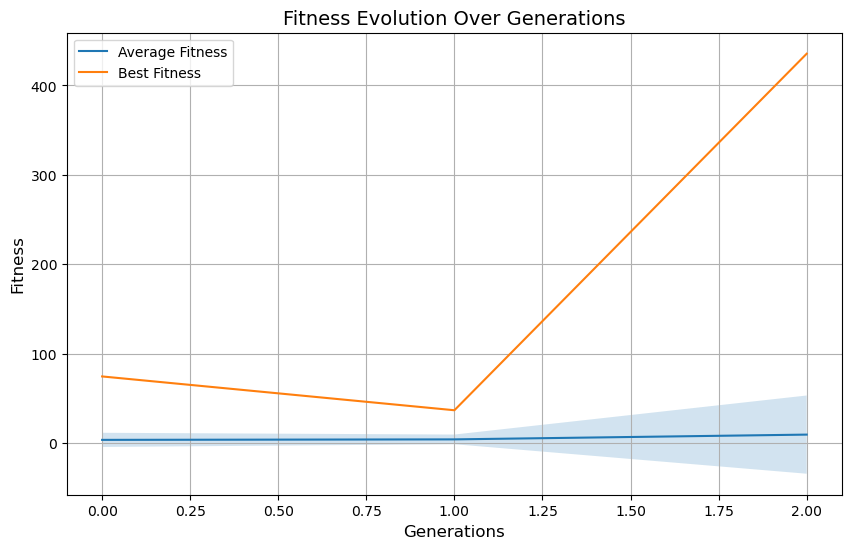

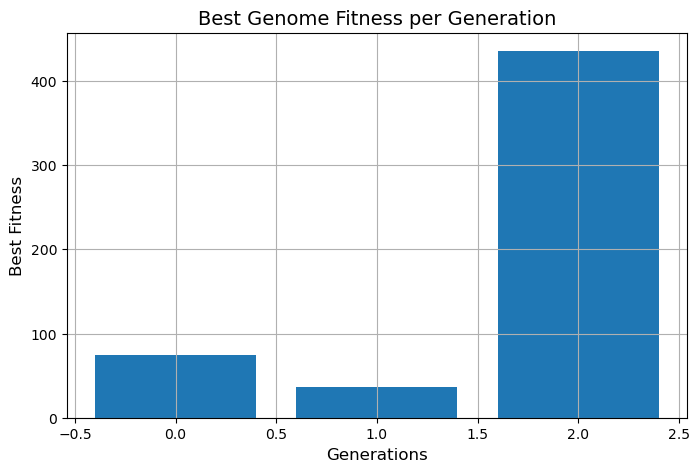

In [1]:
# copy of final prog. 




import pygame
import neat
import os
import random
import time
import matplotlib.pyplot as plt
import numpy as np


pygame.font.init()
pygame.display.set_caption("AI learns to play Flappy Bird Game using NEAT")
DRAW_LINES = True
gen = 0
WIN_WIDTH=500
WIN_HEIGHT=600

BIRD_IMGS = [pygame.transform.scale2x(pygame.image.load(os.path.join("imgs","bird1.png"))),pygame.transform.scale2x(pygame.image.load(os.path.join("imgs","bird2.png"))),pygame.transform.scale2x(pygame.image.load(os.path.join("imgs","bird3.png")))]
PIPE_IMG = pygame.transform.scale2x(pygame.image.load(os.path.join("imgs","pipe.png")))
BASE_IMG = pygame.transform.scale2x(pygame.image.load(os.path.join("imgs","base.png")))
BG_IMG = pygame.transform.scale2x(pygame.image.load(os.path.join("imgs","bg2.png")))

STAT_FONT = pygame.font.SysFont("comicsans",50)

class Bird:
    IMGS = BIRD_IMGS
    MAX_ROTATION = 25
    ROT_VEL = 20
    ANIMATION_TIME = 5
    
    def __init__(self,x,y):
        self.x = x
        self.y = y
        self.tilt = 0
        self.tick_count = 0
        self.vel = 0
        self.height = self.y
        self.img_count = 0
        self.img = self.IMGS[0]
        
    def jump(self):
        self.vel = -10.5
        self.tick_count = 0
        self.height = self.y
        
    def move(self):
        self.tick_count += 1

        d = self.vel * self.tick_count + 1.5 * self.tick_count**2
        if d >= 16:
            d = 16
        if d < 0:
            d -= 2

        self.y += d

        if d < 0 or self.y < self.height + 50:
            if self.tilt < self.MAX_ROTATION:
                self.tilt = self.MAX_ROTATION
        else:
            if self.tilt > -90:
                self.tilt -= self.ROT_VEL
                # print("Current Tilt:", self.tilt)
                
    def draw(self,win):
        self.img_count += 1

        if self.img_count < self.ANIMATION_TIME:
            self.img = self.IMGS[0]

        elif self.img_count < self.ANIMATION_TIME*2:
            self.img = self.IMGS[1]
        elif self.img_count < self.ANIMATION_TIME*3:
            self.img = self.IMGS[2]
        elif self.img_count < self.ANIMATION_TIME*4:
            self.img = self.IMGS[1]
        elif self.img_count == self.ANIMATION_TIME*4+1:
            self.img = self.IMGS[0]
            self.img_count = 0
        if self.tilt <= -80:
            self.img = self.IMGS[1]
            self.img_count = self.ANIMATION_TIME*2

        rotated_img = pygame.transform.rotate(self.img, self.tilt)
        new_rect = rotated_img.get_rect(center=self.img.get_rect(topleft = (self.x, self.y)).center)
        win.blit(rotated_img, new_rect.topleft)

    def get_mask(self):
        return pygame.mask.from_surface(self.img)
    
class Pipe:
    GAP = 200
    VEL = 5
    
    def __init__(self,x):
        self.x = x
        self.height = 0
        
        self.top = 0
        self.bottom = 0
        self.PIPE_TOP = pygame.transform.flip(PIPE_IMG, False, True)
        self.PIPE_BOTTOM = PIPE_IMG
        
        self.passed = False
        self.set_height()
    
    def set_height(self):
        self.height = random.randrange(50,370)
        self.top = self.height - self.PIPE_TOP.get_height()
        self.bottom = (self.height + self.GAP)
        
    def move(self):
        self.x -= self.VEL
        
    def draw(self, win):
        win.blit(self.PIPE_TOP, (self.x, self.top))
        win.blit(self.PIPE_BOTTOM, (self.x, self.bottom))

    def collide(self, bird):
        bird_mask = bird.get_mask()
        top_mask = pygame.mask.from_surface(self.PIPE_TOP)
        bottom_mask = pygame.mask.from_surface(self.PIPE_BOTTOM)
        top_offset = (self.x - bird.x, self.top - round(bird.y))
        bottom_offset = (self.x - bird.x, self.bottom - round(bird.y))

        b_point = bird_mask.overlap(bottom_mask, bottom_offset)
        t_point = bird_mask.overlap(top_mask,top_offset)

        if b_point or t_point:
            return True

        return False

    
class Base:
    VEL = 5
    WIDTH = BASE_IMG.get_width()
    IMG = BASE_IMG

    def __init__(self, y):
        self.y = y
        self.x1 = 0
        self.x2 = self.WIDTH 

    def move(self):
        self.x1 -= self.VEL
        self.x2 -= self.VEL
        if self.x1 + self.WIDTH < 0:
            self.x1 = self.x2 + self.WIDTH

        if self.x2 + self.WIDTH < 0:
            self.x2 = self.x1 + self.WIDTH

    def draw(self, win):
        win.blit(self.IMG, (self.x1, self.y))
        win.blit(self.IMG, (self.x2, self.y))
        
        
        

def draw_window(win, birds, pipes, base, score, gen, pipe_ind):
    win.blit(BG_IMG, (0,0))
    
    for pipe in pipes:
        pipe.draw(win)
        
    text = STAT_FONT.render("Score: " + str(score), 1, (255,255,255))
    win.blit(text,(WIN_WIDTH - 10 - text.get_width(), 10))
    
    text = STAT_FONT.render("Gen: " + str(gen), 1, (255,255,255))
    win.blit(text,(10, 10))
    
    text = STAT_FONT.render("Alive: " + str(len(birds)),1,(255,255,255))
    win.blit(text, (10, 80))
        
    base.draw(win) 
    
    for bird in birds:
        if DRAW_LINES:
            try:
                pygame.draw.line(win, (57, 255, 20), (bird.x+bird.img.get_width()/2, bird.y + bird.img.get_height()/2), (pipes[pipe_ind].x + pipes[pipe_ind].PIPE_TOP.get_width()/2, pipes[pipe_ind].height), 5)
                pygame.draw.line(win, (57, 255, 20), (bird.x+bird.img.get_width()/2, bird.y + bird.img.get_height()/2), (pipes[pipe_ind].x + pipes[pipe_ind].PIPE_BOTTOM.get_width()/2, pipes[pipe_ind].bottom), 5)
            except:
                pass
            
        bird.draw(win)
        
    pygame.display.update()
    
    
        
def main(genomes, config):
    global gen
    gen += 1
    pygame.init()
    nets = []
    ge = []
    birds = []
    
    for _, g in genomes:
        g.fitness = 0 
        net = neat.nn.FeedForwardNetwork.create(g, config)
        nets.append(net)
        birds.append(Bird(230,250))
        ge.append(g)
        
        
    base = Base(530)
    pipes = [Pipe(600)]
    win = pygame.display.set_mode((WIN_WIDTH, WIN_HEIGHT))
    clock = pygame.time.Clock()
    
    score = 0

    run = True
    while run:
        clock.tick(30)
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                run = False
                pygame.quit()
                quit()
        
        
        pipe_ind = 0
        if len(birds) > 0:
            if len(pipes) > 1 and birds[0].x > pipes[0].x + pipes[0].PIPE_TOP.get_width(): 
                pipe_ind = 1  
                
        else:
            run = False
            break
            
        for x, bird in enumerate(birds):  
            ge[x].fitness += 0.1
            bird.move()

            output = nets[birds.index(bird)].activate((bird.y, abs(bird.y - pipes[pipe_ind].height), abs(bird.y - pipes[pipe_ind].bottom)))

            if output[0] > 0.5:
                bird.jump()
        
   
        add_pipe = False
        rem = []
        for pipe in pipes:
            for x, bird in enumerate(birds):
                if pipe.collide(bird):
                    ge[birds.index(bird)].fitness -= 1
                    nets.pop(birds.index(bird))
                    ge.pop(birds.index(bird))
                    birds.pop(birds.index(bird))
            
            if not pipe.passed and pipe.x < bird.x:
                pipe.passed = True
                add_pipe = True
                
            if pipe.x + pipe.PIPE_TOP.get_width()<0:
                rem.append(pipe)
            
            
            pipe.move()
            
        if add_pipe:
            score += 1
            for g in ge:
                g.fitness += 5
            pipes.append(Pipe(600))
            
        for r in rem:
            pipes.remove(r)       
            
        for bird in birds:
            if bird.y + bird.img.get_height() >= 530 or bird.y < 0:
                nets.pop(birds.index(bird))
                ge.pop(birds.index(bird))
                birds.pop(birds.index(bird))    
            
        base.move()
        draw_window(win, birds, pipes, base, score, gen, pipe_ind)
        pygame.display.update()
        

def run (config_path):
    config = neat.config.Config(neat.DefaultGenome, neat.DefaultReproduction, neat.DefaultSpeciesSet, neat.DefaultStagnation, config_path)
    
    p = neat.Population(config)
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    
    winner = p.run(main,50)
    
    
    
    
    
    
    #gemini se uthaya code for plotting graph
    
    
    
    
    generation = range(len(stats.get_fitness_mean()))
    average_fitness = stats.get_fitness_mean()
    best_fitness = stats.get_fitness_stat(max)
    stdev_fitness = np.array(stats.get_fitness_stdev())  # Standard deviation
    
    
    
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed

    # Plot average fitness per generation
    plt.plot(generation, average_fitness, label="Average Fitness")

    # Plot best fitness per generation
    plt.plot(generation, best_fitness, label="Best Fitness")

    # Plot standard deviation (optional)
    plt.fill_between(generation, average_fitness - stdev_fitness, average_fitness + stdev_fitness, alpha=0.2)

    plt.xlabel("Generations", fontsize=12)
    plt.ylabel("Fitness", fontsize=12)
    plt.title("Fitness Evolution Over Generations", fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()
    
    
    
    # Create a new figure for the bar plot
    plt.figure(figsize=(8, 5))  # Adjust figure size as needed

    plt.bar(generation, best_fitness)
    plt.xlabel("Generations", fontsize=12)
    plt.ylabel("Best Fitness", fontsize=12)
    plt.title("Best Genome Fitness per Generation", fontsize=14)
    plt.grid(True)
    plt.show()
    
            
                
if __name__ == "__main__":
    current_dir = os.getcwd()
    config_path = os.path.join(current_dir, "feedforward.txt")
    run(config_path)

In [2]:
pip install pygame



  Obtaining dependency information for pygame from https://files.pythonhosted.org/packages/1b/e0/edce124be8f73249e6b862e13107adc1f7e3b275ed9468d018026b6fbf91/pygame-2.6.0-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/10.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.8 MB 1.3 MB/s eta 0:00:09
   ---------------------------------------- 0.1/10.8 MB 656.4 kB/s eta 0:00:17
   ---------------------------------------- 0.1/10.8 MB 939.4 kB/s eta 0:00:12
   ---------------------------------------- 0.1/10.8 MB 939.4 kB/s eta 0:00:12
   - -------------------------------------- 0.3/10.8 MB 1.3 MB/s eta 0:00:08
   - -------------------------------------- 0.3/10.8 MB 1.2 MB/s eta 0:00:09
   - -------------------------------------- 0.4/10.8 MB 1.3 MB/s eta 0:00:08
   -- ------------------------------------- 0.7/10.8 MB 1.8 MB/s eta 0:00:06
   -- ------------------------------------- 0.7/10.8 MB 1.8 MB/s eta 0:00:06
   -- ------------------

In [3]:
pip install python-neat

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement python-neat (from versions: none)
ERROR: No matching distribution found for python-neat


In [4]:
pip install os

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [5]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [7]:
pip install neat-python

Note: you may need to restart the kernel to use updated packages.
